# Dictionary Initialization

In [14]:
daily_log_likelihoods = {}
daily_regrets = {}

# collections for plotting charts about the performance of the EWMA predictor
betaValues = []
ewmaMeanRegretValues = []
ewmaMeanlogLikelihoodValues = []
prescientAlreadyPrinted = False

# Import Data

In [15]:
from cvx.covariance.ewma import iterated_ewma, _ewma_cov, _ewma_mean
from cvx.covariance.combination import from_sigmas

from predictorStarter import * # this file contains the import of every dataset, libraries needed and the initial plotting of the data
from predictorsImplementation import * # this file contains the implementation of the predictors ( one function implementation for each predictor)

# Covariance Predictors(EWMA)

FOR THE EWMA PREDICTOR THERE IS NO TRAINING PHASE, THE PREDICTOR HAS BETA AS UNIQUE PARAMETER AND IT IS AN HYPERPARAMETER (0 < BETA < 1). 
The best value for beta has been found with the grid search method applied in the validation phase.

# Validation Phase for EWMA predictor

In [16]:
# Loop through beta values
# ewma_halflife = 100
# beta = 2 ** (-1 / ewma_halflife)
# beta = 0.1

def ewmaValidationPhase(betaValue, startingDate, endingDate, betaIncrement, prescientAlreadyPrinted):
    '''
    this function is used to perform the validation phase of the EWMA predictor; it's used to find the best beta value for the EWMA predictor.
    Grid search is used and the performance of the beta hyperparameter is evaluated using the MSE, log-likelihood and regret metrics.
    '''

    while betaValue < 1:

        ewma_halflife = -np.log(2) / np.log(betaValue)
        ewmaDict = dict(_ewma_cov(stocksPercentageChangeReturn, halflife=ewma_halflife))

        #
        # DEFINE END AND START DATES FOR BACKTESTS
        #
        
        start_date = pd.to_datetime(startingDate, format="%Y-%m-%d")
        end_date = pd.to_datetime(endingDate, format="%Y-%m-%d")

        names = ["EWMA", "PRESCIENT"]

        #these predictors are all dictionaries where each entry contains a Pandas DataFrame representing a covariance matrix of returns at each timestamp.  
        predictors_temp = [ewmaDict, prescientDict]
        predictors = [] # so this is a list of dictionaries

        for predictor in predictors_temp:
            predictors.append({t: predictor[t] for t in predictor.keys() if t >= start_date and t <= end_date})

        #
        # LOG-LIKELIHOODS
        #

        '''
            this dictionary has a shape like this:
            {
                RW: pd.Series(log_likelihood(returns_temp, Sigmas_temp), index=times),
                EWMA: pd.Series(log_likelihood(returns_temp, Sigmas_temp), index=times),
                MGARCH: pd.Series(log_likelihood(returns_temp, Sigmas_temp), index=times),
                PRESCIENT: pd.Series(log_likelihood(returns_temp, Sigmas_temp), index=times),
            }

            where each pd.series is a series of log-likelihoods for each timestamp: so there is the log-likelihood value for each timestamp
        '''

        for i, predictorDict in enumerate(predictors):

            # if the predictor is the prescient predictor, i have to use the uniformly distributed dataset
            if names[i] == "PRESCIENT":
                returns_temp = uniformlyDistributedReturns.loc[pd.Series(predictorDict).index].values[1:]
            
            else:
                returns_temp = stocksPercentageChangeReturn.loc[pd.Series(predictorDict).index].values[1:]

            times = pd.Series(predictorDict).index[1:]
            Sigmas_temp = np.stack([predictorDict[t].values for t in predictorDict.keys()])[:-1]       
            daily_log_likelihoods[names[i]] = pd.Series(log_likelihood(returns_temp, Sigmas_temp), index=times)


        #
        # REGRETS
        #

        for name in daily_log_likelihoods:
            daily_regrets[name] =  daily_log_likelihoods["PRESCIENT"] - daily_log_likelihoods[name]
            
        for name in daily_regrets:
            if name != "PRESCIENT":

                #Each data point in the regret series now represents the average regret for a respective quarter. If the original series spans multiple years, then the number of data points in regret will be the number of quarters in that time frame.
                quarterly_regrets = daily_regrets[name].resample("Q").mean() #it resamples the regret Series to a quarterly frequency, This gives the average regret for each quarter rather than daily regret values  
                # so the regret variable is a series of average regret for each quarter
                
                regretMetrics = (np.mean(quarterly_regrets).round(1), np.std(quarterly_regrets).round(1), np.max(quarterly_regrets).round(1))
                # the round(1) function to each of these metrics, which rounds the result to one decimal place,

                # save the regret mean values to plot a chart
                ewmaMeanRegretValues.append(regretMetrics[0])


        # copy the log-likelihoods dictionary
        daily_log_likelihoods_copy = daily_log_likelihoods.copy()

        # do the same thing for log-likelihoods dictionary
        for name in daily_log_likelihoods_copy:
            quarterly_logLikelihood = daily_log_likelihoods_copy[name].resample("Q").mean()
            logLikelihoodMetrics = (np.mean(quarterly_logLikelihood).round(1), np.std(quarterly_logLikelihood).round(1), np.max(quarterly_logLikelihood).round(1))

            if name != "PRESCIENT":

                # save the loglikelihood mean values to plot a chart
                ewmaMeanlogLikelihoodValues.append(logLikelihoodMetrics[0])
                
            if name == "PRESCIENT" and prescientAlreadyPrinted == False:
                prescientAlreadyPrinted = True

                # save the loglikelihood mean value to plot a chart
                prescientMeanlogLikelihoodValue = logLikelihoodMetrics[0]

        # save every fundamental value to plot a chart 
        betaValues.append(betaValue)

        # Increment beta
        betaValue += betaIncrement

    print("lenght of ewmaDict: ", len(ewmaDict))
    print("first timestamp of ewmaDict: ", list(ewmaDict.keys())[0])
    print("last timestamp of ewmaDict: ", list(ewmaDict.keys())[-1])

    # return the fundamental values to plot a chart
    return betaValues, ewmaMeanRegretValues, ewmaMeanlogLikelihoodValues, prescientMeanlogLikelihoodValue

In [17]:
# this function is used to plot the performance of the ewma predictor in terms of regret and log-likelihood

def plotLogLikelihoodPerformanceEWMA(betaValues, ewmaMeanlogLikelihoodValues, prescientMeanlogLikelihoodValue):
    '''
    plotting the results of the grid search expressed in terms of regret
    '''

    betaMaxValuesLogLikelihood = [] # this list will contain the beta values that have the max loglikelihood value

    # plot the chart of the mean loglikelihood values
    plt.figure()
    plt.plot(betaValues, ewmaMeanlogLikelihoodValues)
    plt.xlabel("Beta values")
    plt.ylabel("Mean loglikelihood values")
    plt.title("Mean loglikelihood values for different beta values")

    # show the prescient predictor loglikelihood value
    plt.axhline(y=prescientMeanlogLikelihoodValue, color='r', linestyle='-')
    plt.legend(["EWMA", "PRESCIENT"])

    for j in range(len(ewmaMeanlogLikelihoodValues)):
        if ewmaMeanlogLikelihoodValues[j] == max(ewmaMeanlogLikelihoodValues):
            betaMaxValuesLogLikelihood.append(betaValues[j])

    # these points show the interval of beta values that have the max loglikelihood value
    highlightPoint1LogLikelihood = betaMaxValuesLogLikelihood[0]
    plt.scatter(highlightPoint1LogLikelihood, max(ewmaMeanlogLikelihoodValues), color='r')
    #plt.text(highlightPoint1LogLikelihood, max(ewmaMeanlogLikelihoodValues), f' Beta: {highlightPoint1LogLikelihood:.4f}\n Loglikelihood: {max(ewmaMeanlogLikelihoodValues):.4f}',
            #fontsize=9, color='red', ha='center', va='bottom')

    highlightPoint2LogLikelihood = betaMaxValuesLogLikelihood[-1]
    plt.scatter(highlightPoint2LogLikelihood, max(ewmaMeanlogLikelihoodValues), color='r')
    #plt.text(highlightPoint2LogLikelihood, max(ewmaMeanlogLikelihoodValues), f' Beta: {highlightPoint2LogLikelihood:.4f}\n Loglikelihood: {max(ewmaMeanlogLikelihoodValues):.4f}',
            #fontsize=9, color='red', ha='center', va='bottom')

    # find the y value coordinate corresponding to the highlightPoint1LogLikelihood and highlightPoint2LogLikelihood
    highlightPoint1LogLikelihoodIndex = betaValues.index(highlightPoint1LogLikelihood)
    highlightPoint1LogLikelihoodY = ewmaMeanlogLikelihoodValues[highlightPoint1LogLikelihoodIndex]

    highlightPoint2LogLikelihoodIndex = betaValues.index(highlightPoint2LogLikelihood)
    highlightPoint2LogLikelihoodY = ewmaMeanlogLikelihoodValues[highlightPoint2LogLikelihoodIndex]

    print("highlightPoint1LogLikelihoodX: " + str(highlightPoint1LogLikelihood))
    print("highlightPoint1LogLikelihoodY: " + str(highlightPoint1LogLikelihoodY))

    print("highlightPoint2LogLikelihoodX: " + str(highlightPoint2LogLikelihood))
    print("highlightPoint2LogLikelihoodY: " + str(highlightPoint2LogLikelihoodY))

    # set the x-axis limits 
    plt.xlim(left = betaValues[0], right = betaValues[-1])
    
    plt.show()


def plotRegretperformanceEWMA(betaValues, ewmaMeanRegretValues):
    '''
    plotting the results of the grid search expressed in terms of regret
    '''

    betaMinValuesRegret = [] # this list will contain the beta values that have the minimum regret value

    # plot the chart of the mean regret values
    plt.figure()
    plt.plot(betaValues, ewmaMeanRegretValues)
    plt.xlabel("Beta values")
    plt.ylabel("Mean regret values")
    plt.title("Mean regret values for different beta values")

    # find the minimum value of the mean regret values
    for i in range(len(ewmaMeanRegretValues)):
        if ewmaMeanRegretValues[i] == min(ewmaMeanRegretValues):
            betaMinValuesRegret.append(betaValues[i])

    # these points show the interval of beta values that have the minimum regret value
    highlightPoint1 = betaMinValuesRegret[0]
    plt.scatter(highlightPoint1, min(ewmaMeanRegretValues), color='r')
    #plt.text(highlightPoint1, min(ewmaMeanRegretValues), f' Beta: {highlightPoint1:.4f}\n Regret: {min(ewmaMeanRegretValues):.4f}',
            #fontsize=9, color='red', ha='center', va='bottom')

    highlightPoint2 = betaMinValuesRegret[-1]
    plt.scatter(highlightPoint2, min(ewmaMeanRegretValues), color='r')
    #plt.text(highlightPoint2, min(ewmaMeanRegretValues), f' Beta: {highlightPoint2:.4f}\n Regret: {min(ewmaMeanRegretValues):.4f}',
            #fontsize=9, color='red', ha='center', va='bottom')

    # find the y value coordinate corresponding to the highlightPoint1 and highlightPoint2
    highlightPoint1Index = betaValues.index(highlightPoint1)
    highlightPoint1Y = ewmaMeanRegretValues[highlightPoint1Index]

    highlightPoint2Index = betaValues.index(highlightPoint2)
    highlightPoint2Y = ewmaMeanRegretValues[highlightPoint2Index]
    
    print("highlightPoint1X: " + str(highlightPoint1))
    print("highlightPoint1Y: " + str(highlightPoint1Y))
    
    print("highlightPoint2X: " + str(highlightPoint2))
    print("highlightPoint2Y: " + str(highlightPoint2Y))

    # set the x-axis limits 
    plt.xlim(left = betaValues[0], right = betaValues[-1])

    plt.show()

In [18]:
def plotPerformanceEWMA(betaValues, ewmaMeanlogLikelihoodValues, prescientMeanlogLikelihoodValue, ewmaMeanRegretValues):
    '''
    plotting the results of the grid search expressed in terms of loglikelihood and regret on a single chart
    '''
    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Plot the mean log-likelihood values for EWMA
    color = 'tab:blue'
    ax1.set_xlabel('Beta values')
    ax1.set_ylabel('Mean log-likelihood', color=color)
    ax1.plot(betaValues, ewmaMeanlogLikelihoodValues, color=color, label='Loglikelihood EWMA')
    ax1.tick_params(axis='y', labelcolor=color)

    # Plot the loglikelihood value of the prescient predictor
    ax1.axhline(y=prescientMeanlogLikelihoodValue, color='tab:green', linestyle='-', label='Loglikelihood PRESCIENT')

    # Highlight the maximum log-likelihood points
    max_log_likelihood = max(ewmaMeanlogLikelihoodValues)
    max_points = [beta for beta, value in zip(betaValues, ewmaMeanlogLikelihoodValues) if value == max_log_likelihood]

    # take just the first and last element of the list
    max_points = [max_points[0], max_points[-1]]

    # scatter the points by writing the beta value and the loglikelihood value on the chart
    for point in max_points:
        ax1.scatter(point, max_log_likelihood, color='green')
        plt.text(point, max_log_likelihood, f' x: {point:.3f}\n y: {max_log_likelihood:.3f}', fontsize=9, color='green', ha='center', va='bottom')

    # Add a second y-axis for the regret values
    ax2 = ax1.twinx()  
    color = 'tab:red'
    ax2.set_ylabel('Mean regret', color=color)  
    ax2.plot(betaValues, ewmaMeanRegretValues, color=color, label='Regret EWMA')
    ax2.tick_params(axis='y', labelcolor=color)

    # Highlight the minimum regret points
    min_regret = min(ewmaMeanRegretValues)
    min_points = [beta for beta, value in zip(betaValues, ewmaMeanRegretValues) if value == min_regret]

    # take just the first and last element of the list
    min_points = [min_points[0], min_points[-1]]

    # scatter the points by writing the beta value and the regret value on the chart
    for point in min_points:
        ax2.scatter(point, min_regret, color='red')
        plt.text(point, min_regret, f' x: {point:.3f}\n y: {min_regret:.3f}', fontsize=9, color='red', ha='center', va='bottom')

    print("max_points: " + str(max_points))
    print("min_points: " + str(min_points))

    # Create the legend, which combines both axes
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc='center')

    # Add title
    plt.title("Performance of EWMA for different beta values")

    # Set the x-axis limits
    ax1.set_xlim(left=betaValues[0], right=betaValues[-1])

    fig.tight_layout()  # to ensure the right y-label is not slightly clipped
    plt.show()


In [19]:
# first of all define the starting and ending date for the validation phase: take the first and the last date of the validation dataset
startingValidationDate = validationDataWithPercentageChange.index[0].strftime("%Y-%m-%d")
endingValidationDate = validationDataWithPercentageChange.index[-1].strftime("%Y-%m-%d")

In [20]:
'''
# first run for grid search -> this is a general run to cover the entire range of beta values
betaValues, ewmaMeanRegretValues, ewmaMeanlogLikelihoodValues, prescientMeanlogLikelihoodValue = ewmaValidationPhase(0.1, startingValidationDate, endingValidationDate, 0.01, prescientAlreadyPrinted)

# plot the performance of the EWMA predictor in terms of loglikelihood
plotLogLikelihoodPerformanceEWMA(betaValues, ewmaMeanlogLikelihoodValues, prescientMeanlogLikelihoodValue)

# plot the performance of the EWMA predictor in terms of regret
plotRegretperformanceEWMA(betaValues, ewmaMeanRegretValues)

plotPerformanceEWMA(betaValues, ewmaMeanlogLikelihoodValues, prescientMeanlogLikelihoodValue, ewmaMeanRegretValues)
'''

'\n# first run for grid search -> this is a general run to cover the entire range of beta values\nbetaValues, ewmaMeanRegretValues, ewmaMeanlogLikelihoodValues, prescientMeanlogLikelihoodValue = ewmaValidationPhase(0.1, startingValidationDate, endingValidationDate, 0.01, prescientAlreadyPrinted)\n\n# plot the performance of the EWMA predictor in terms of loglikelihood\nplotLogLikelihoodPerformanceEWMA(betaValues, ewmaMeanlogLikelihoodValues, prescientMeanlogLikelihoodValue)\n\n# plot the performance of the EWMA predictor in terms of regret\nplotRegretperformanceEWMA(betaValues, ewmaMeanRegretValues)\n\nplotPerformanceEWMA(betaValues, ewmaMeanlogLikelihoodValues, prescientMeanlogLikelihoodValue, ewmaMeanRegretValues)\n'

From the chart is evident that the model has the best performance with 0.9 < beta < 1; so now i will do the zoom in this range

In [21]:
# to go faster i skip the validation part(the correct memoru value parameter has been already found)


'''
# clear the lists to make another run of the grid search
betaValues.clear()
ewmaMeanRegretValues.clear()
ewmaMeanlogLikelihoodValues.clear()
prescientMeanlogLikelihoodValue = 0

# this is a specific run to find the best beta value (i will search in the range 0.9 -> 1 with a step of 0.001)
betaValues, ewmaMeanRegretValues, ewmaMeanlogLikelihoodValues, prescientMeanlogLikelihoodValue = ewmaValidationPhase(0.9, startingValidationDate, endingValidationDate, 0.001, prescientAlreadyPrinted)

# plot the performance of the EWMA predictor in terms of loglikelihood
plotLogLikelihoodPerformanceEWMA(betaValues, ewmaMeanlogLikelihoodValues, prescientMeanlogLikelihoodValue)

# plot the performance of the EWMA predictor in terms of regret
plotRegretperformanceEWMA(betaValues, ewmaMeanRegretValues)

plotPerformanceEWMA(betaValues, ewmaMeanlogLikelihoodValues, prescientMeanlogLikelihoodValue, ewmaMeanRegretValues)
'''

'\n# clear the lists to make another run of the grid search\nbetaValues.clear()\newmaMeanRegretValues.clear()\newmaMeanlogLikelihoodValues.clear()\nprescientMeanlogLikelihoodValue = 0\n\n# this is a specific run to find the best beta value (i will search in the range 0.9 -> 1 with a step of 0.001)\nbetaValues, ewmaMeanRegretValues, ewmaMeanlogLikelihoodValues, prescientMeanlogLikelihoodValue = ewmaValidationPhase(0.9, startingValidationDate, endingValidationDate, 0.001, prescientAlreadyPrinted)\n\n# plot the performance of the EWMA predictor in terms of loglikelihood\nplotLogLikelihoodPerformanceEWMA(betaValues, ewmaMeanlogLikelihoodValues, prescientMeanlogLikelihoodValue)\n\n# plot the performance of the EWMA predictor in terms of regret\nplotRegretperformanceEWMA(betaValues, ewmaMeanRegretValues)\n\nplotPerformanceEWMA(betaValues, ewmaMeanlogLikelihoodValues, prescientMeanlogLikelihoodValue, ewmaMeanRegretValues)\n'

In [22]:
'''
# print the log likelihood value and regret value for beta = 0.97
Beta = 0.9870000000000001
ewma_halflife = -np.log(2) / np.log(Beta)

print("betavalues: " + str(betaValues))

print("beta: " + str(Beta))
print("ewma_halflife: " + str(ewma_halflife))
print("log likelihood: " + str(ewmaMeanlogLikelihoodValues[betaValues.index(Beta)]))
print("regret: " + str(ewmaMeanRegretValues[betaValues.index(Beta)]))
'''

'\n# print the log likelihood value and regret value for beta = 0.97\nBeta = 0.9870000000000001\newma_halflife = -np.log(2) / np.log(Beta)\n\nprint("betavalues: " + str(betaValues))\n\nprint("beta: " + str(Beta))\nprint("ewma_halflife: " + str(ewma_halflife))\nprint("log likelihood: " + str(ewmaMeanlogLikelihoodValues[betaValues.index(Beta)]))\nprint("regret: " + str(ewmaMeanRegretValues[betaValues.index(Beta)]))\n'

In [23]:
'''
# example of behaviour with a bad beta value
prescientAlreadyPrinted = False
startingvalidationDate = validationDataWithPercentageChange.index[0].strftime("%Y-%m-%d")
endingvalidationDate = validationDataWithPercentageChange.index[-1].strftime("%Y-%m-%d")

# select the best beta value for the EWMA predictor (the one found in the previous step)
beta = 0.1

ewma_halflife = -np.log(2) / np.log(beta)

# now i will use the best beta value to perform the test phase

# now i want to print the repective value of beta: the beta is the value of the decay factor used in the ewma formula
print("ewma_halflife used: " + str(ewma_halflife) + "\n")

# ewma is a dictionary that contains the covariance matrix calculated using the ewma formula written inside the paper
# the key of the dictionary is the timestamp and the value is the covariance matrix calculated for that day
ewmaDict = dict(_ewma_cov(validationDataWithPercentageChange, ewma_halflife))

# now filter the ewma volatilities between the start and end date
real_volatility_startDate = pd.to_datetime(startingvalidationDate)
real_volatility_endDate = pd.to_datetime(endingvalidationDate)

df_ewma_volatility_aapl, df_ewma_volatility_ibm, df_ewma_volatility_mcd, ewma_volatility_dict_aapl, ewma_volatility_dict_ibm, ewma_volatility_dict_mcd = plot_volatility(ewmaDict, real_volatility_startDate, real_volatility_endDate, 'EWMA')
'''

'\n# example of behaviour with a bad beta value\nprescientAlreadyPrinted = False\nstartingvalidationDate = validationDataWithPercentageChange.index[0].strftime("%Y-%m-%d")\nendingvalidationDate = validationDataWithPercentageChange.index[-1].strftime("%Y-%m-%d")\n\n# select the best beta value for the EWMA predictor (the one found in the previous step)\nbeta = 0.1\n\newma_halflife = -np.log(2) / np.log(beta)\n\n# now i will use the best beta value to perform the test phase\n\n# now i want to print the repective value of beta: the beta is the value of the decay factor used in the ewma formula\nprint("ewma_halflife used: " + str(ewma_halflife) + "\n")\n\n# ewma is a dictionary that contains the covariance matrix calculated using the ewma formula written inside the paper\n# the key of the dictionary is the timestamp and the value is the covariance matrix calculated for that day\newmaDict = dict(_ewma_cov(validationDataWithPercentageChange, ewma_halflife))\n\newma_volatilities = {}\n\nfor d

In [24]:
'''
# HERE THERE IS THE VOLATILITY ANALYSIS OF THE EWMA PREDICTOR COMPARED TO THE REAL VOLATILITY
startDateFilter = validationDataWithPrices.index[0]
endDateFilter = validationDataWithPrices.index[-1]

plot_prices_volatilities_for_ewma(validationDataWithPrices, df_volatility_aapl['AAPL Volatility'], startDateFilter, endDateFilter, df_ewma_volatility_aapl['AAPL Volatility'], 'AAPL')
'''

"\n# HERE THERE IS THE VOLATILITY ANALYSIS OF THE EWMA PREDICTOR COMPARED TO THE REAL VOLATILITY\nstartDateFilter = validationDataWithPrices.index[0]\nendDateFilter = validationDataWithPrices.index[-1]\n\nplot_prices_volatilities_for_ewma(validationDataWithPrices, df_volatility_aapl['AAPL Volatility'], startDateFilter, endDateFilter, df_ewma_volatility_aapl['AAPL Volatility'], 'AAPL')\n"

# Test Phase for EWMA predictor

In this test phase i will use the best value for beta found in the validation phase to see the performance of the model on the test set and i will plot some charts to compare the volatility predicted by the model with the ground truth.

ewma_halflife used: 13.513407333964874



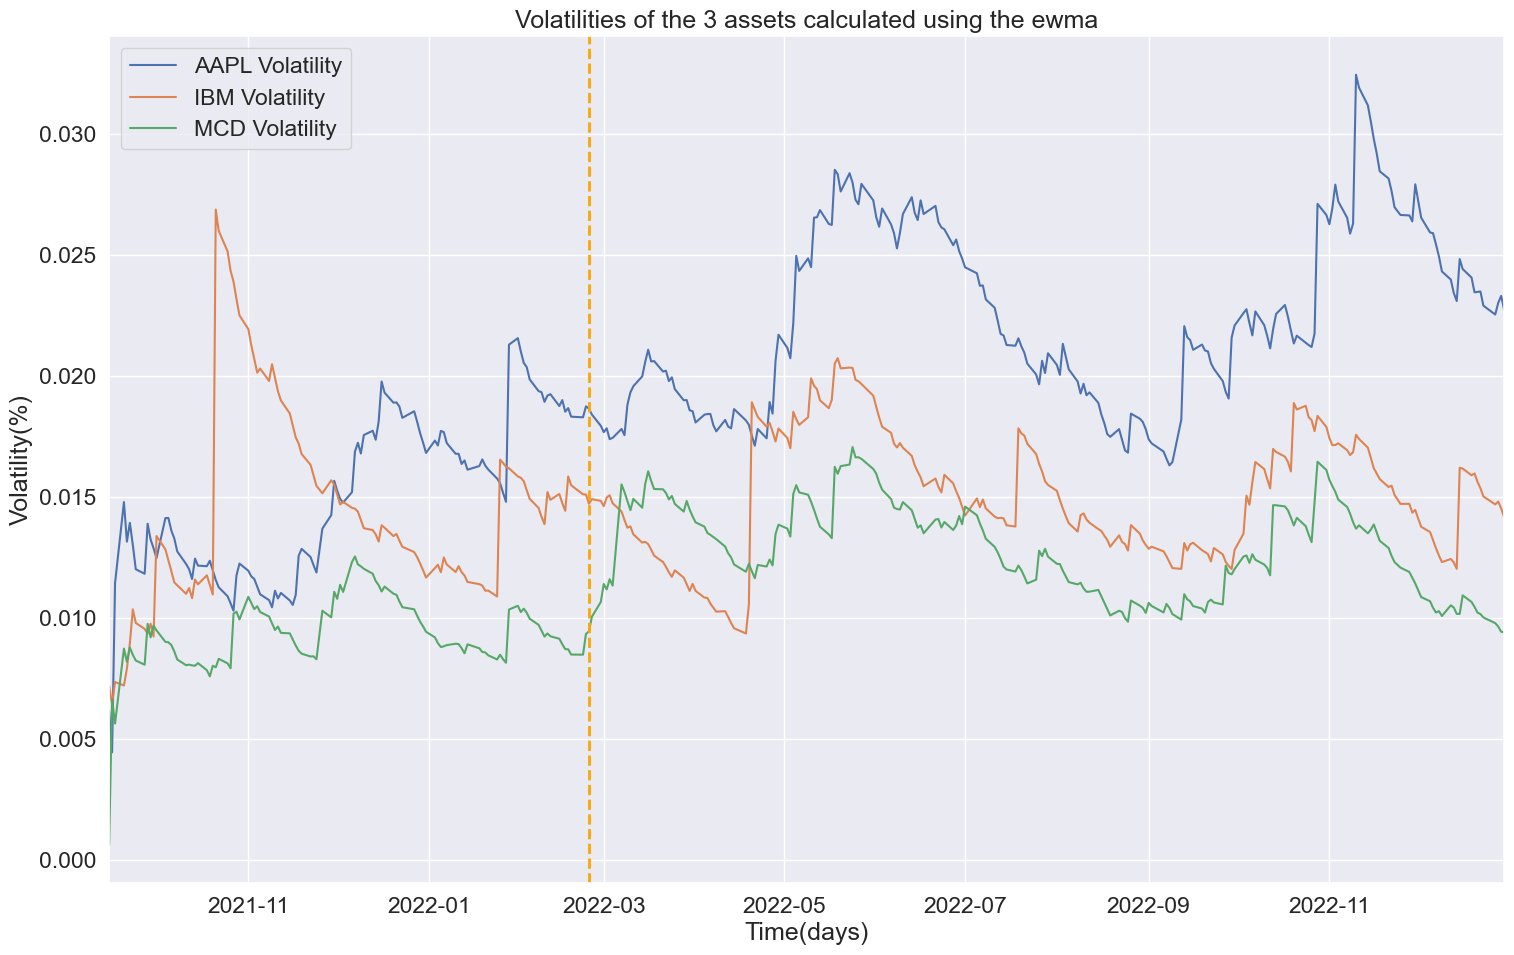

In [25]:
# prepare the date for the test phase
prescientAlreadyPrinted = False
startingTestDate = testDataWithPercentageChange.index[0].strftime("%Y-%m-%d")
endingTestDate = testDataWithPercentageChange.index[-1].strftime("%Y-%m-%d")

# select the best beta value for the EWMA predictor (the one found in the previous step)
beta = predictorsConfiguration["EWMA_beta"]
ewma_halflife = -np.log(2) / np.log(beta)

# now i will use the best beta value to perform the test phase

# now i want to print the repective value of beta: the beta is the value of the decay factor used in the ewma formula
print("ewma_halflife used: " + str(ewma_halflife) + "\n")

# ewma is a dictionary that contains the covariance matrix calculated using the ewma formula written inside the paper
# the key of the dictionary is the timestamp and the value is the covariance matrix calculated for that day
ewmaDict = dict(_ewma_cov(testDataWithPercentageChange, ewma_halflife))

# now filter the ewma volatilities between the start and end date
real_volatility_startDate = pd.to_datetime(startingTestDate)
real_volatility_endDate = pd.to_datetime(endingTestDate)

df_ewma_volatility_aapl, df_ewma_volatility_ibm, df_ewma_volatility_mcd, ewma_volatility_dict_aapl, ewma_volatility_dict_ibm, ewma_volatility_dict_mcd = plot_volatility(ewmaDict, real_volatility_startDate, real_volatility_endDate, 'EWMA')

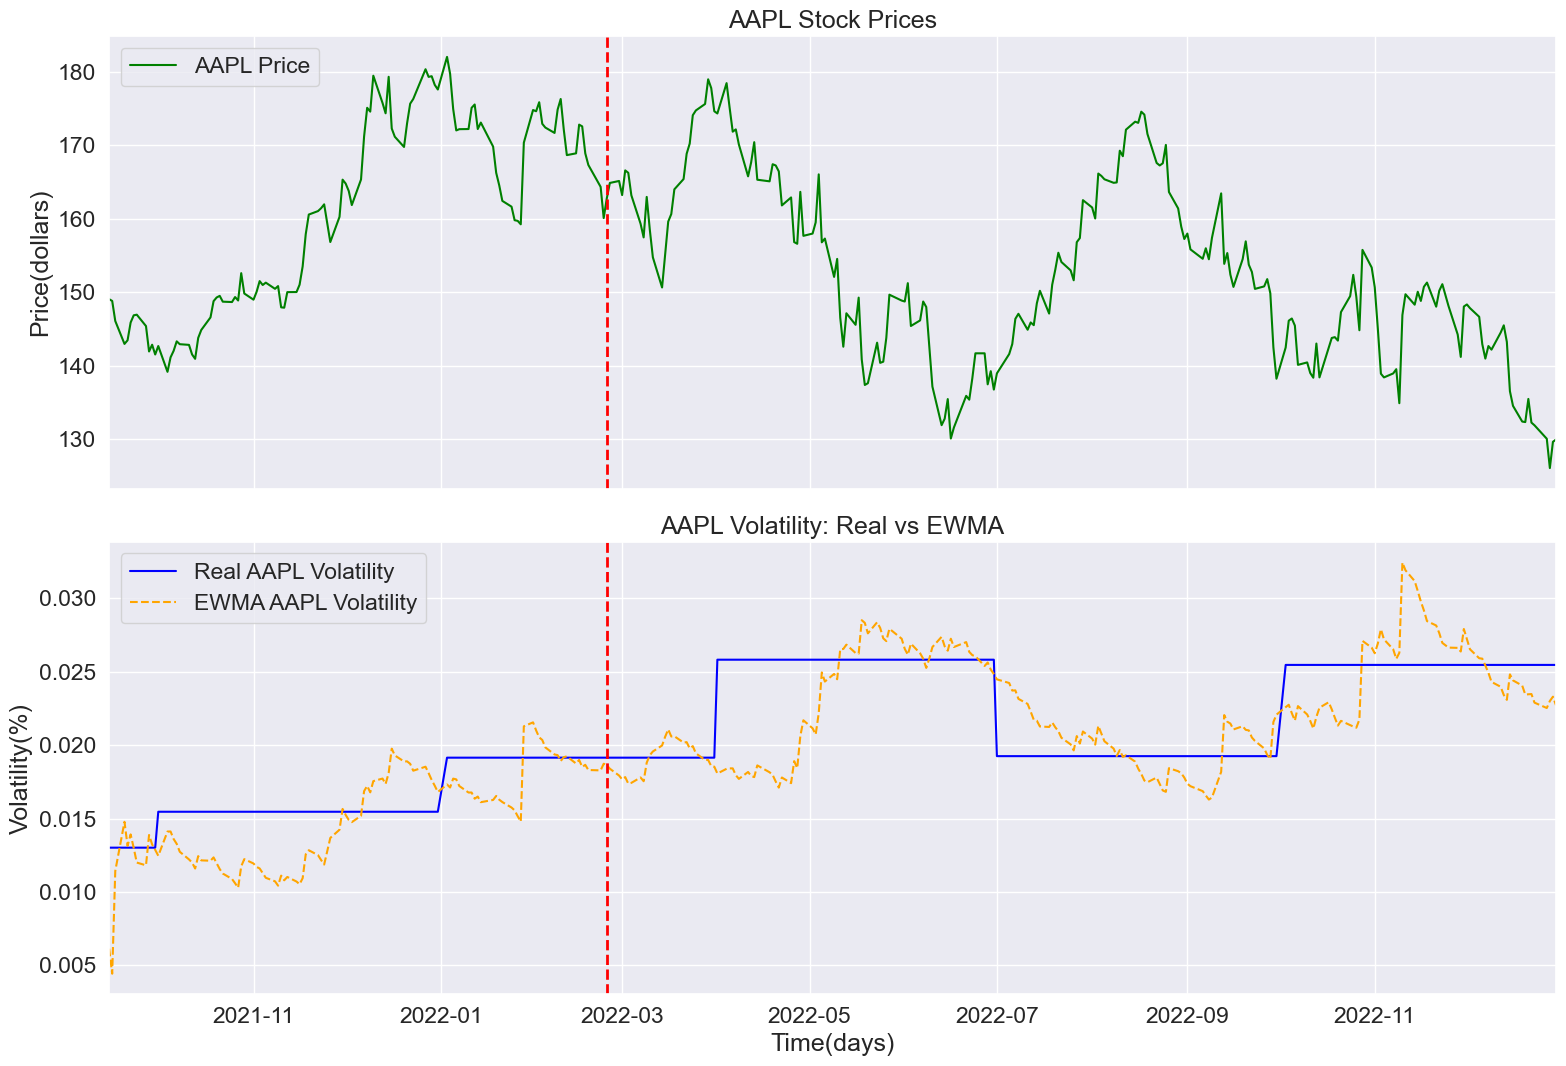

In [26]:
# HERE THERE IS THE VOLATILITY ANALYSIS OF THE EWMA PREDICTOR COMPARED TO THE REAL VOLATILITY
startDateFilter = testDataWithPrices.index[0]
endDateFilter = testDataWithPrices.index[-1]

plot_prices_volatilities_for_predictor(testDataWithPrices, df_volatility_aapl['AAPL Volatility'], startDateFilter, endDateFilter, df_ewma_volatility_aapl['AAPL Volatility'], 'AAPL', "EWMA")

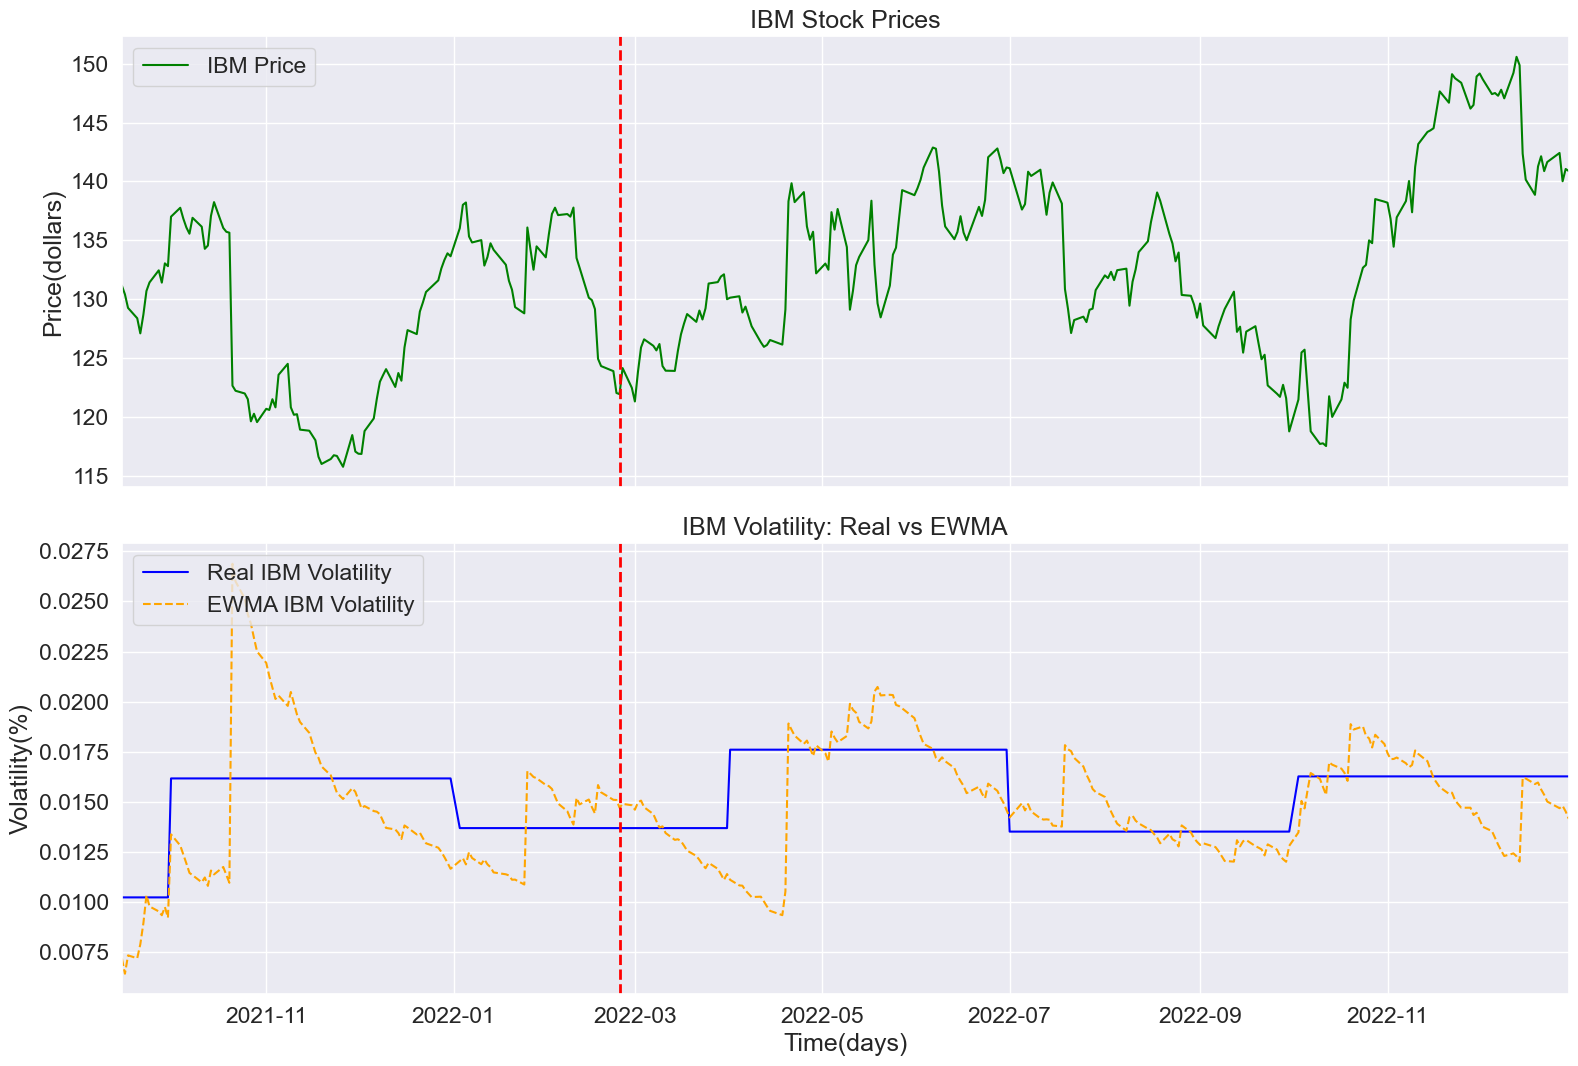

In [27]:
plot_prices_volatilities_for_predictor(testDataWithPrices, df_volatility_ibm['IBM Volatility'], startDateFilter, endDateFilter, df_ewma_volatility_ibm['IBM Volatility'], 'IBM', "EWMA")

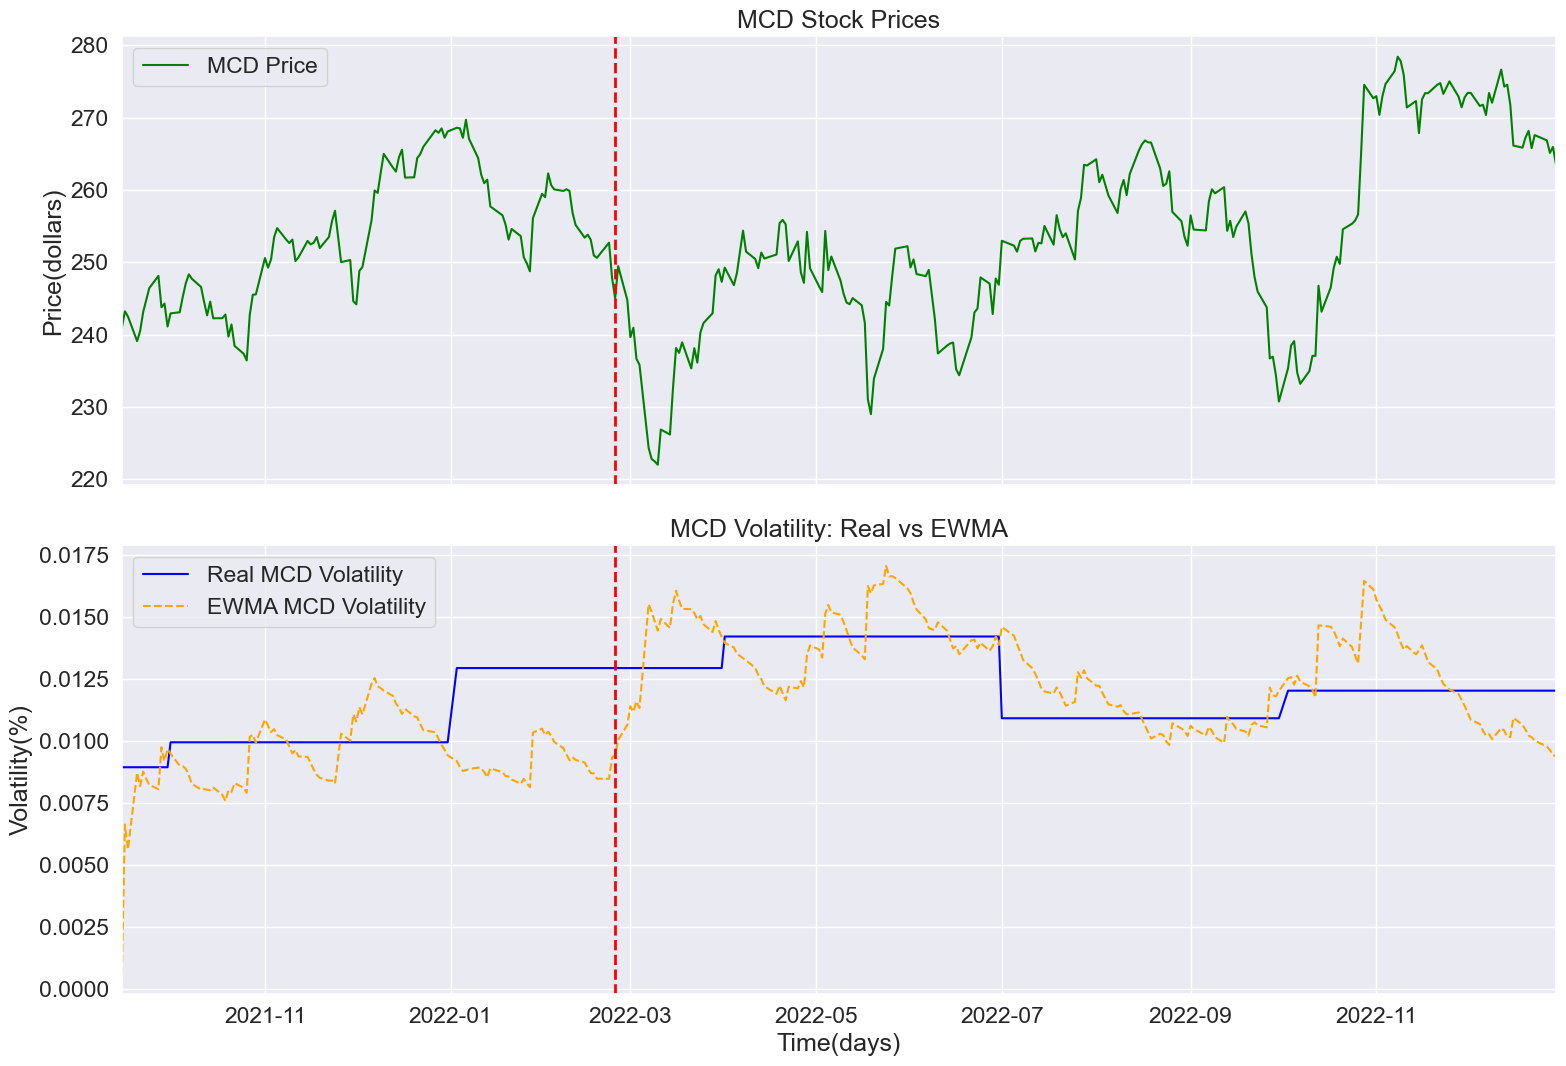

In [28]:
plot_prices_volatilities_for_predictor(testDataWithPrices, df_volatility_mcd['MCD Volatility'], startDateFilter, endDateFilter, df_ewma_volatility_mcd['MCD Volatility'], 'MCD', "EWMA")

size of the first predictor: 308
size of the second predictor: 308
first timestamp of the first predictor: 2021-10-12 00:00:00
first timestamp of the second predictor: 2021-10-12 00:00:00


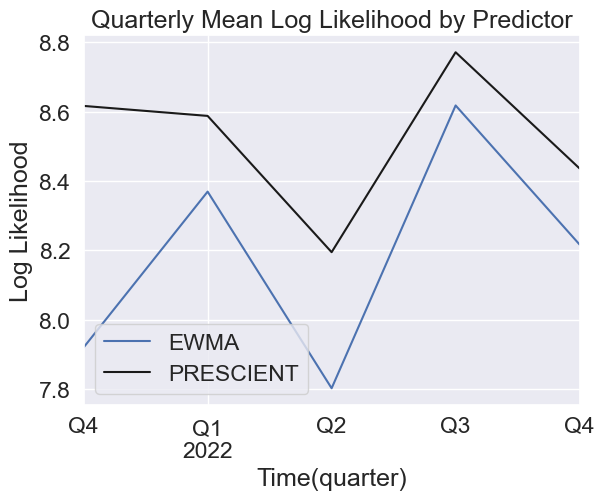



meanRegret: 0.300
stdRegret: 0.200
maxRegret: 0.700


meanLoglikelihoodEWMA: 8.200
stdLoglikelihoodEWMA: 0.300
maxLoglikelihoodEWMA: 8.600


meanLoglikelihoodPRESCIENT: 8.500
stdLoglikelihoodPRESCIENT: 0.200
maxLoglikelihoodPRESCIENT: 8.800
lenght of prescientDict:  3272
lenght of ewmaDict:  327
lenght of predictorDict:  308

EWMA RMSE
mean: 0.0138895248
std: 0.0017768174
max: 0.0169567752
lenght of rmses:  5
values of rmses:  {Timestamp('2022-01-02 00:00:00'): 0.013473559901956825, Timestamp('2022-03-31 00:00:00'): 0.012433935472057813, Timestamp('2022-06-30 00:00:00'): 0.016956775216509245, Timestamp('2022-10-02 00:00:00'): 0.011993454142127704, Timestamp('2022-12-29 00:00:00'): 0.01458989928367914}


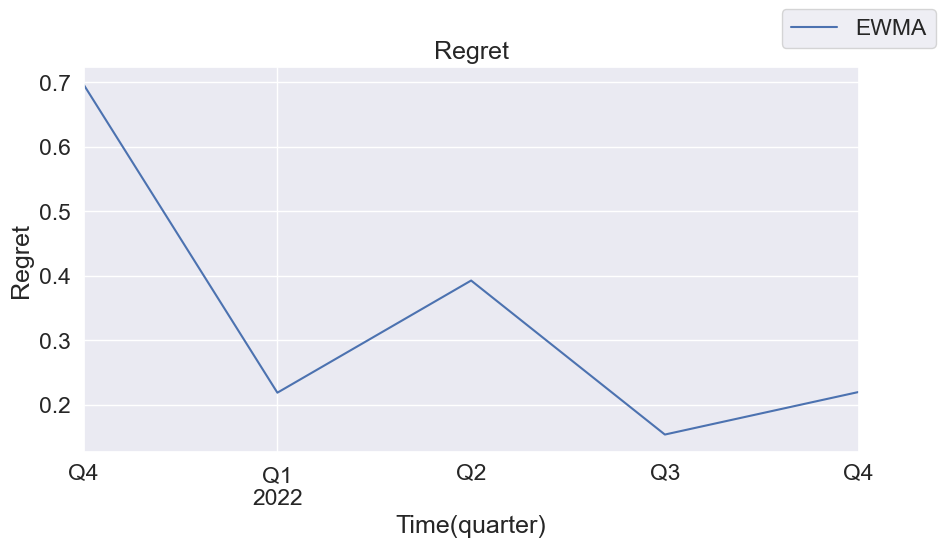

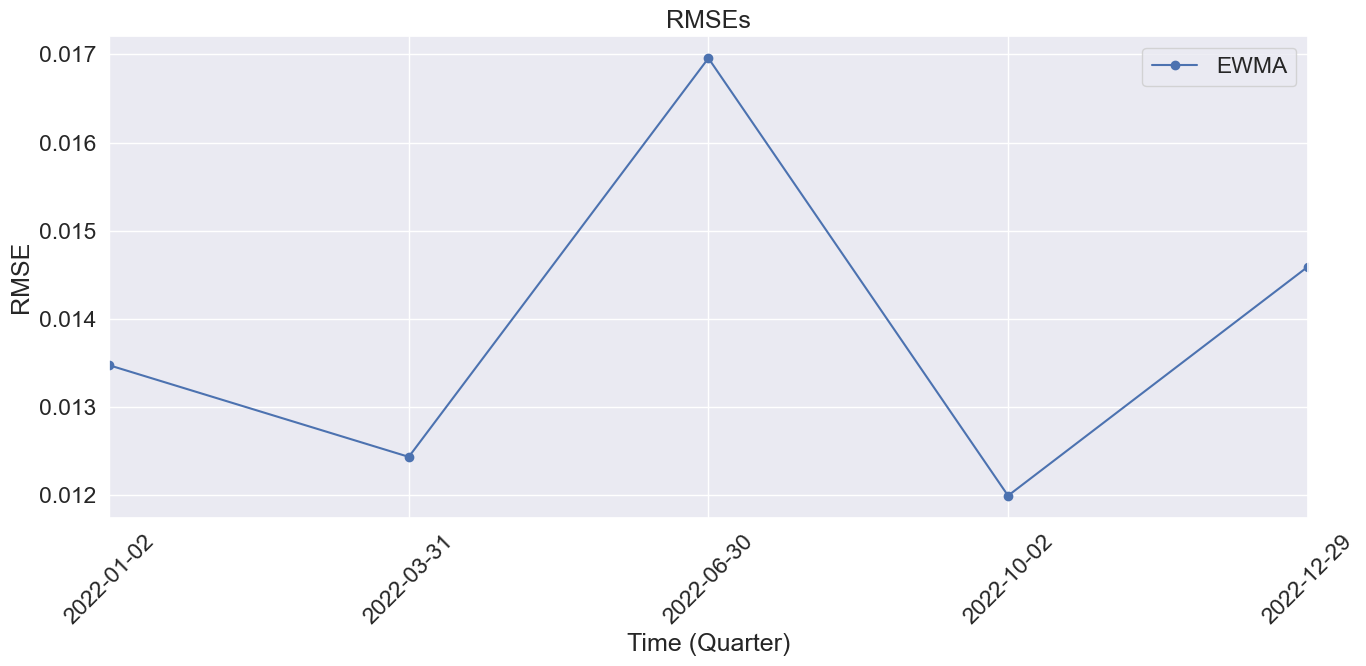

lenght of volatility_dict_aapl:  308
lenght of volatility_dict_aaapl_ewma:  308
lenght of RMSEs_aapl:  5
values of RMSEs_aapl:  {Timestamp('2022-01-02 00:00:00'): 0.056340296783108805, Timestamp('2022-03-31 00:00:00'): 0.042076461246691586, Timestamp('2022-06-30 00:00:00'): 0.06709495516227268, Timestamp('2022-10-02 00:00:00'): 0.04639449923018044, Timestamp('2022-12-29 00:00:00'): 0.054089782436078274}


RMSEs for AAPL
mean: 0.0531991990
std: 0.0086460501
max: 0.0670949552


RMSEs for IBM
mean: 0.0489590973
std: 0.0104167134
max: 0.0634332283


RMSEs for MCD
mean: 0.0417817856
std: 0.0084665191
max: 0.0574243273


In [29]:
# NOW I DO THE LAST THING; THE COMPARISON BETWEEN THE EWMA PREDICTOR AND THE PRESCIENT PREDICTOR IN TERMS OF 
# LOGLIKELIHOOD, LOGLIKELIHOOD REGRET AND MSE

# first of all define the starting and ending date for the test phase: take the first and the last date of the test dataset

startingTestDate = testDataWithPercentageChange.index[0].strftime("%Y-%m-%d")
endingTestDate = testDataWithPercentageChange.index[-1].strftime("%Y-%m-%d")

start_date = pd.to_datetime(startingTestDate, format="%Y-%m-%d")
end_date = pd.to_datetime(endingTestDate, format="%Y-%m-%d")

names = ["EWMA", "PRESCIENT"]

#these predictors are all dictionaries where each entry contains a Pandas DataFrame representing a covariance matrix of returns at each timestamp.  
predictors_temp = [ewmaDict, prescientDict]
predictors = [] # so this is a list of dictionaries

for predictor in predictors_temp:
    predictors.append({t: predictor[t] for t in predictor.keys() if t >= start_date and t <= end_date})


ewmaDictionary = predictors[0]
ewmaDictionary = {k: ewmaDictionary[k] for k in list(ewmaDictionary)[19:]}
predictors[0] = ewmaDictionary

# now remove the first 19 entries from the predictor 1(prescient dict)
prescientDictionary = predictors[1]

# now remove the first 19 entries from the prescient dict
prescientDictionary = {k: prescientDictionary[k] for k in list(prescientDictionary)[19:]}
predictors[1] = prescientDictionary

print("size of the first predictor: " + str(len(predictors[0])))
print("size of the second predictor: " + str(len(predictors[1])))


# make an assert to check if the length of the two predictors is the same
assert len(predictors[0]) == len(predictors[1])

# make an assert to check if the timestamps of the two predictors are the same
assert predictors[0].keys() == predictors[1].keys()

# print the first timestamp of the two predictors
print("first timestamp of the first predictor: " + str(list(predictors[0].keys())[0]))
print("first timestamp of the second predictor: " + str(list(predictors[1].keys())[0]))

# if we are here, it means that the two predictors have the same length and the same timestamps so i can measure the performance of the two predictors


#
# LOG-LIKELIHOODS
#

'''
    this dictionary has a shape like this:
    {
        RW: pd.Series(log_likelihood(returns_temp, Sigmas_temp), index=times),
        EWMA: pd.Series(log_likelihood(returns_temp, Sigmas_temp), index=times),
        ewma: pd.Series(log_likelihood(returns_temp, Sigmas_temp), index=times),
        PRESCIENT: pd.Series(log_likelihood(returns_temp, Sigmas_temp), index=times),
    }

    where each pd.series is a series of log-likelihoods for each timestamp: so there is the log-likelihood value for each timestamp
'''

log_likelihoods = {}
for i, predictorDict in enumerate(predictors):

    # if the predictor is the prescient predictor, i have to use the uniformly distributed dataset
    if names[i] == "PRESCIENT":
        returns_temp = uniformlyDistributedReturns.loc[pd.Series(predictorDict).index].values[1:]
    
    else:
        returns_temp = stocksPercentageChangeReturn.loc[pd.Series(predictorDict).index].values[1:]

    times = pd.Series(predictorDict).index[1:]
    Sigmas_temp = np.stack([predictorDict[t].values for t in predictorDict.keys()])[:-1]       
    log_likelihoods[names[i]] = pd.Series(log_likelihood(returns_temp, Sigmas_temp), index=times)


# Iterate through each predictor in the log_likelihoods dictionary
for name in log_likelihoods.keys():
    if name == 'PRESCIENT':
        # Resample by quarter, take the mean, and plot with specific color and label
        log_likelihoods[name].resample("Q").mean().plot(label=name, c="k")
    else:
        # Resample by quarter, take the mean, and plot with default settings
        log_likelihoods[name].resample("Q").mean().plot(label=name)


plt.xlabel('Time(quarter)')  # Set the x-axis label
plt.ylabel('Log Likelihood')  # Set the y-axis label
plt.title('Quarterly Mean Log Likelihood by Predictor')  # Set the title of the plot
plt.legend()  # Show the legend to identify each predictor
plt.show()  # Display the plot

'''
    this dictionary has a shape like this:
    {
        RW: pd.Series(...),
        EWMA: pd.Series(...),
        ewma: pd.Series(...),
        PRESCIENT: pd.Series(...),
    }

    where each pd.series is a series of regret for each timestamp: so there is the 
    regret value (the difference between the log-likelihood of the prescient model and the log-likelihood of the model) for each timestamp
'''
regrets = {}
for name in log_likelihoods:
    regrets[name] =  log_likelihoods["PRESCIENT"] - log_likelihoods[name]


fig, ax = plt.subplots(1, 1, figsize=(10, 5))
for name in names:
    if name == 'PRESCIENT':
        pass
    else:
        regrets[name].resample("Q").mean().plot(label=name)
plt.legend(bbox_to_anchor=(1, 1.1), loc='center', ncols=4, labels=names[:-1], scatterpoints=1, markerscale=5);
plt.xlabel("Time(quarter)")
plt.ylabel("Regret")
plt.title("Regret")

for name in regrets:
    if name != "PRESCIENT":

        #Each data point in the regret series now represents the average regret for a respective quarter. If the original series spans multiple years, then the number of data points in regret will be the number of quarters in that time frame.
        regret = regrets[name].resample("Q").mean() #it resamples the regret Series to a quarterly frequency, This gives the average regret for each quarter rather than daily regret values  
        # so the regret variable is a series of average regret for each quarter
        
        regretMetrics = (np.mean(regret).round(1), np.std(regret).round(1), np.max(regret).round(1))
        # the round(1) function to each of these metrics, which rounds the result to one decimal place,

        # save the regret mean values to plot a chart
        ewmaMeanRegretValues.append(regretMetrics[0])

print("\n")
print(f"meanRegret: {regretMetrics[0]:.3f}")
print(f"stdRegret: {regretMetrics[1]:.3f}")
print(f"maxRegret: {regretMetrics[2]:.3f}")

# copy the log-likelihoods dictionary
log_likelihoods_copy = log_likelihoods.copy()

# do the same thing for log-likelihoods dictionary
for name in log_likelihoods_copy:
    logLikelihood = log_likelihoods_copy[name].resample("Q").mean()
    logLikelihoodMetrics = (np.mean(logLikelihood).round(1), np.std(logLikelihood).round(1), np.max(logLikelihood).round(1))

    print("\n")
    print(f"meanLoglikelihood{name}: {logLikelihoodMetrics[0]:.3f}")
    print(f"stdLoglikelihood{name}: {logLikelihoodMetrics[1]:.3f}")
    print(f"maxLoglikelihood{name}: {logLikelihoodMetrics[2]:.3f}")


#
# RMSEs
#

print("lenght of prescientDict: ", len(prescientDict))
print("lenght of ewmaDict: ", len(ewmaDict))
        
for i, predictorDict in enumerate(predictors):
    if names[i] != "PRESCIENT":
        print("lenght of predictorDict: ", len(predictorDict))
        RMSEs = RMSE(testDataWithPercentageChange, predictorDict, prescientDict, start_date)
        print("\n" + names[i] + " RMSE")

        # Calculate mean, standard deviation, and max value of the RMSEs
        mean_rmse = np.mean(list(RMSEs.values()))
        std_rmse = np.std(list(RMSEs.values()))
        max_rmse = np.max(list(RMSEs.values()))

        print(f"mean: {mean_rmse:.10f}")
        print(f"std: {std_rmse:.10f}")
        print(f"max: {max_rmse:.10f}")


print("lenght of rmses: ", len(RMSEs))
print("values of rmses: ", RMSEs)

# Convert Timestamps to strings for plotting
timestamps = [ts.strftime('%Y-%m-%d') for ts in RMSEs.keys()]
rmse_values = list(RMSEs.values())

# Plot the RMSEs with improved formatting
plt.figure(figsize=(14, 7))  # Increase the figure size for better readability
plt.plot(timestamps, rmse_values, marker='o', linestyle='-', label='EWMA', color='b')

# Set the x-axis to only include the dates from the dictionary
plt.xticks(timestamps, rotation=45)

# Remove the left margin
plt.margins(x=0)

# Add labels and title
plt.xlabel('Time (Quarter)')
plt.ylabel('RMSE')
plt.title('RMSEs')
plt.legend()

# Adjust the layout
plt.tight_layout()

# Show the plot
plt.show()

#
# RMSEs for single assets
#
        
# take the first timestamp contained in prescientDict and use it as the start date
startDAte = list(prescientDictionary.keys())[0]

# filter every volatility dictionary to get only the values that are greater than or equal to the start date
volatility_dict_aapl_filtered = {k: v for k, v in volatility_dict_aapl.items() if k >= startDAte}
volatility_dict_ibm_filtered = {k: v for k, v in volatility_dict_ibm.items() if k >= startDAte}
volatility_dict_mcd_filtered = {k: v for k, v in volatility_dict_mcd.items() if k >= startDAte}

volatility_dict_aapl_ewma_filtered = {k: v for k, v in ewma_volatility_dict_aapl.items() if k >= startDAte}
volatility_dict_ibm_ewma_filtered = {k: v for k, v in ewma_volatility_dict_ibm.items() if k >= startDAte}
volatility_dict_mcd_ewma_filtered = {k: v for k, v in ewma_volatility_dict_mcd.items() if k >= startDAte}


print("lenght of volatility_dict_aapl: ", len(volatility_dict_aapl_filtered))
print("lenght of volatility_dict_aaapl_ewma: ", len(volatility_dict_aapl_ewma_filtered))
# get the rmse of single assets. i take just aapl, ibm and mcd
        
RMSEs_aapl_dict = RMSEforSingleVolatility(testDataWithPercentageChange, volatility_dict_aapl_filtered, volatility_dict_aapl_ewma_filtered, start_date)
RMSEs_ibm_dict = RMSEforSingleVolatility(testDataWithPercentageChange, volatility_dict_ibm_filtered, volatility_dict_ibm_ewma_filtered, start_date)
RMSEs_mcd_dict = RMSEforSingleVolatility(testDataWithPercentageChange, volatility_dict_mcd_filtered, volatility_dict_mcd_ewma_filtered, start_date)

print("lenght of RMSEs_aapl: ", len(RMSEs_aapl_dict))
print("values of RMSEs_aapl: ", RMSEs_aapl_dict)

print("\n")
print("RMSEs for AAPL")

# Calculate mean, standard deviation, and max value of the RMSEs. the RMSEs are dictionaries whose key is the timestamp and the value is the rmse value
mean_rmse_aapl = np.mean(list(RMSEs_aapl_dict.values()))
std_rmse_aapl = np.std(list(RMSEs_aapl_dict.values()))
max_rmse_aapl = np.max(list(RMSEs_aapl_dict.values()))

print(f"mean: {mean_rmse_aapl:.10f}")
print(f"std: {std_rmse_aapl:.10f}")
print(f"max: {max_rmse_aapl:.10f}")

print("\n")
print("RMSEs for IBM")

# Calculate mean, standard deviation, and max value of the RMSEs. the RMSEs are dictionaries whose key is the timestamp and the value is the rmse value
mean_rmse_ibm = np.mean(list(RMSEs_ibm_dict.values()))
std_rmse_ibm = np.std(list(RMSEs_ibm_dict.values()))
max_rmse_ibm = np.max(list(RMSEs_ibm_dict.values()))

print(f"mean: {mean_rmse_ibm:.10f}")
print(f"std: {std_rmse_ibm:.10f}")
print(f"max: {max_rmse_ibm:.10f}")

print("\n")
print("RMSEs for MCD")

# Calculate mean, standard deviation, and max value of the RMSEs. the RMSEs are dictionaries whose key is the timestamp and the value is the rmse value
mean_rmse_mcd = np.mean(list(RMSEs_mcd_dict.values()))
std_rmse_mcd = np.std(list(RMSEs_mcd_dict.values()))
max_rmse_mcd = np.max(list(RMSEs_mcd_dict.values()))

print(f"mean: {mean_rmse_mcd:.10f}")
print(f"std: {std_rmse_mcd:.10f}")
print(f"max: {max_rmse_mcd:.10f}")

Now here i store all the variables that i need to pass to other notebooks.

In [30]:
# create a dictionary for the volatilities of the rw predictor
ewma_volatilities = {}

# add the volatilities of the 3 assets to the dictionary
ewma_volatilities["AAPL"] = volatility_dict_aapl_ewma_filtered
ewma_volatilities["IBM"] = volatility_dict_ibm_ewma_filtered
ewma_volatilities["MCD"] = volatility_dict_mcd_ewma_filtered

# store the dictionary
%store ewma_volatilities


Stored 'ewma_volatilities' (dict)
